In [1]:
!nvidia-smi

Sat Mar 29 13:57:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [4]:
ds = load_dataset("dair-ai/emotion", "split")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(samples):
      return tokenizer(samples["text"], padding="max_length", truncation=True, max_length=128)
tokenized_datasets = ds.map(tokenize_function, batched=True)
data = tokenized_datasets.copy()
tokenized_datasets.remove_columns('text')
tokenized_datasets.set_format("torch")
batch_size=32
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=batch_size*4, shuffle=False)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=batch_size*4, shuffle=False)
print(f"{len(train_dataloader.dataset)} train samples, {len(validation_dataloader.dataset)} validation samples, {len(test_dataloader.dataset)} test samples")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


16000 train samples, 2000 validation samples, 2000 test samples


In [5]:
# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(device)
output_dim = len(torch.unique(tokenized_datasets['train']['label']))
print(device)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5) # torch.optim.Adam(model.parameters(), lr=1e-4)

cuda
cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
batch_train = next(iter(train_dataloader))
batch_val = next(iter(validation_dataloader))
target, source, mask = batch_train['label'], batch_train['input_ids'], batch_train['attention_mask']
target_v, source_v, mask_v = batch_val['label'], batch_val['input_ids'], batch_val['attention_mask']
print(f'{target.shape}, {source.shape}, {mask.shape}')

torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128])


Epoch:  10%|█         | 1/10 [10:33<1:35:05, 633.98s/it]

Training Break


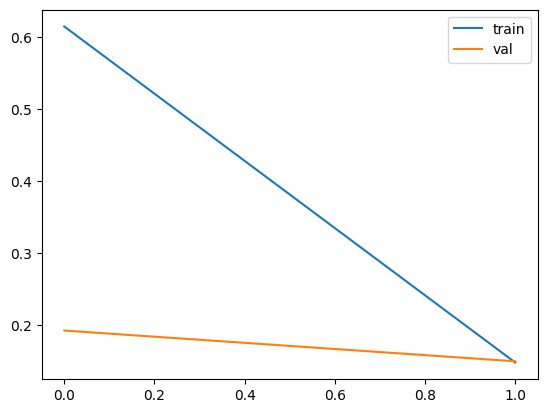

In [7]:
# Training params
n_epochs = 10
model = model.to(device)
train_losses = []
val_losses = []

for e in tqdm(range(n_epochs), desc="Epoch: "):
    # device = torch.device("mps" if torch.mps.is_available() else "cpu" )
    losstot = 0
    model.to(device)
    model.train()
    for i, batch in enumerate(train_dataloader):
        target, source, mask = batch['label'], batch['input_ids'], batch['attention_mask']
        target = target.to(device)
        source = source.to(device)
        mask = mask.to(device).bool()
        outputs = model(source, mask)
        loss = criterion(outputs.logits, target)
        start_time = time.time()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        stop_time = time.time()
        losstot += loss.item()
    train_error = losstot/(len(train_dataloader))
    train_losses.append(train_error)
    losstot = 0

    with torch.no_grad():
        model.eval()
        model.to(device)
        for i, val_batch in enumerate(validation_dataloader):
            target, source, mask = val_batch['label'], val_batch['input_ids'], val_batch['attention_mask']
            target = target.to(device)
            source = source.to(device)
            mask = mask.to(device).bool()
            outputs = model(source, mask)
            loss = criterion(outputs.logits, target)
            losstot += loss.item()
    val_error = losstot/(len(validation_dataloader))
    val_losses.append(val_error)

    if val_error > min(val_losses) + 0.05 or val_error > train_error:
        print("Training Break")
        break
sns.lineplot(train_losses, label="train")
sns.lineplot(val_losses, label="val")
plt.show()

In [8]:
losstot = 0
correct = 0

with torch.no_grad():  # Pas de calcul des gradients
    model.eval()  # Mode évaluation
    model.to(device)
    for i, val_batch in enumerate(test_dataloader):  # Traitement par batch
        target, source, mask = val_batch['label'], val_batch['input_ids'], val_batch['attention_mask']
        target = target.to(device)
        source = source.to(device)
        mask = mask.to(device).bool()
        # Passage avant
        outputs = model(source, mask)
        # Calcul de la perte
        loss = criterion(outputs.logits, target)
        # Calcul des prédictions
        predicted = torch.argmax(outputs.logits, dim=1)
        correct += (predicted == target).sum().item()
        losstot += loss.item()  # Additionne la perte

# Calcul de la précision
accuracy = 100 * correct / len(test_dataloader.dataset)

print(f'Loss: {losstot / len(test_dataloader)}')  # Afficher la perte moyenne
print(f'Accuracy: {accuracy}%')  # Afficher la précision en pourcentage

Loss: 0.1613140986301005
Accuracy: 92.65%


In [10]:
torch.save(model.state_dict(), 'bert_model.pth')

In [14]:
import numpy as np
np.savez("model_bert_stats.npz", train_losses=np.array(train_losses), valid_losses=np.array(val_losses), allow_pickle=True)